In [17]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv(r"C:\Users\cks12\Downloads\PML Project\dataset\raw\CleanDataset.csv")
df.corr()['Attrition'].sort_values()

WorkExperience                     -0.216722
MonthlyIncome                      -0.202379
CurrentProfile                     -0.198538
Age                                -0.180490
MaritalStatus_Married              -0.165064
Designation_Manager                -0.141719
Designation_AVP                    -0.115766
Department_Analytics               -0.114451
Designation_VP                     -0.072545
EducationField_CA                  -0.052707
TravelProfile_Rarely               -0.051362
Gender_F                           -0.048519
EducationField_Statistics          -0.048031
LastPromotion                      -0.038565
Designation_Senior Manager         -0.032605
Unnamed: 0                         -0.023067
EmployeeID                         -0.023067
SalaryHikelastYear                 -0.006778
Department_Marketing                0.010778
ESOPs                               0.012200
WorkLifeBalance                     0.013608
HourlnWeek                          0.021145
EducationF

In [6]:
X=df[['Age','WorkExperience','MonthlyIncome','CurrentProfile','OverTime','MaritalStatus_Single']]

In [7]:
y=df['Attrition']

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [9]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

In [19]:
import pymc as pm
import numpy as np

with pm.Model():
    w = pm.Normal("w", mu=0, sigma=1, shape=Xtrain_scaled.shape[1])
    logits = pm.math.dot(Xtrain_scaled, w)
    y_obs = pm.Bernoulli("y_obs", logit_p=logits, observed=ytrain)
    trace = pm.sample(100, tune=100, return_inferencedata=True)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 30 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


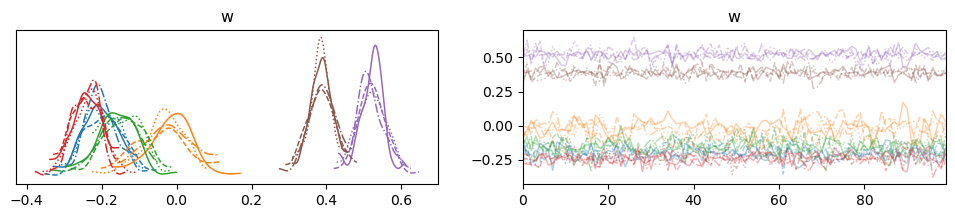

In [20]:
import arviz as az

az.plot_trace(trace)
plt.show()



In [21]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],-0.200,0.047,-0.278,-0.108,0.003,0.002,317.0,341.0,1.01
w[1],-0.029,0.065,-0.147,0.108,0.005,0.004,183.0,264.0,1.01
w[2],-0.150,0.054,-0.267,-0.061,0.004,0.003,237.0,242.0,1.01
w[3],-0.240,0.041,-0.328,-0.170,0.002,0.001,447.0,368.0,1.00
w[4],0.521,0.037,0.439,0.592,0.002,0.001,592.0,314.0,1.02
w[5],0.386,0.034,0.323,0.457,0.001,0.001,893.0,362.0,1.03


In [22]:
def predict(Xtest, trace):
    from scipy.special import expit
    w_samples = trace.posterior["w"].stack(sample=("chain", "draw")).values.T
    logits = Xtest @ w_samples.T
    probs = expit(logits)
    mean_probs = probs.mean(axis=1)
    return mean_probs, (mean_probs > 0.5).astype(int)

# Example usage
probs, preds = predict(Xtest_scaled, trace)



In [23]:
accuracy_score(ytest,preds)

0.6664092664092665

In [24]:
values, counts = np.unique(preds, return_counts=True)

for val, count in zip(values, counts):
    print(f"Value: {val}, Count: {count}")

Value: 0, Count: 673
Value: 1, Count: 622


In [10]:
import pymc as pm
import numpy as np

with pm.Model():
    w = pm.Normal("w", mu=0, sigma=1, shape=Xtrain_scaled.shape[1])
    logits = pm.math.dot(Xtrain_scaled, w)
    y_obs = pm.Bernoulli("ytest", logit_p=logits, observed=ytrain)
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


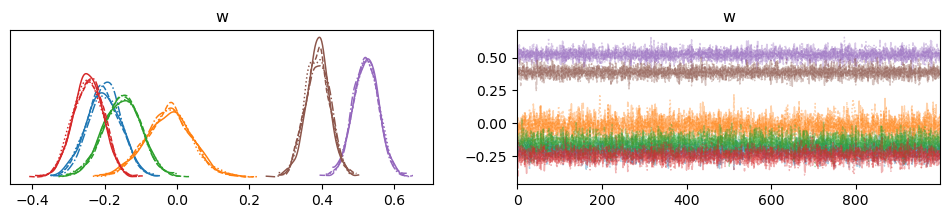

In [11]:
import arviz as az

az.plot_trace(trace)
plt.show()



In [12]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],-0.202,0.047,-0.302,-0.119,0.001,0.001,3641.0,2858.0,1.0
w[1],-0.023,0.064,-0.157,0.095,0.001,0.001,3113.0,2398.0,1.0
w[2],-0.152,0.052,-0.256,-0.054,0.001,0.001,4517.0,3005.0,1.0
w[3],-0.246,0.042,-0.324,-0.165,0.001,0.000,4733.0,3141.0,1.0
w[4],0.522,0.035,0.456,0.593,0.000,0.000,6334.0,3061.0,1.0
w[5],0.388,0.034,0.321,0.454,0.000,0.000,6939.0,3122.0,1.0


In [13]:
def predict(Xtest, trace):
    from scipy.special import expit
    w_samples = trace.posterior["w"].stack(sample=("chain", "draw")).values.T
    logits = Xtest @ w_samples.T
    probs = expit(logits)
    mean_probs = probs.mean(axis=1)
    return mean_probs, (mean_probs > 0.5).astype(int)

# Example usage
probs, preds = predict(Xtest_scaled, trace)



In [14]:
values, counts = np.unique(preds, return_counts=True)

for val, count in zip(values, counts):
    print(f"Value: {val}, Count: {count}")

Value: 0, Count: 674
Value: 1, Count: 621


In [18]:
accuracy_score(ytest,preds)

0.6671814671814672